# A Simulation Study for Time-varying coefficients

In [1]:
import math
from math import pi
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.spatial.distance import cdist

from orbit.models.ktrx import KTRXFull, KTRXAggregated
from orbit.models.ktrlite import KTRLiteMAP
from orbit.estimators.pyro_estimator import PyroEstimatorVI, PyroEstimatorMAP
from orbit.estimators.stan_estimator import StanEstimatorMAP
from orbit.diagnostics.metrics import smape
from orbit.utils.features import make_fourier_series_df, make_fourier_series
from orbit.diagnostics.plot import plot_predicted_data

plt.style.use('fivethirtyeight')

%load_ext autoreload
%autoreload 2

# Data Simulation Modules

In [2]:
def sim_data_seasonal(n, RS):
    """ coefficients curve are sine-cosine like
    """
    np.random.seed(RS)
    # make the time varing coefs  
    tau = np.arange(1, n+1)/n
    data = pd.DataFrame({
        'tau': tau,
        'date': pd.date_range(start='1/1/2018', periods=n),
        'beta1': 2 * tau,
        'beta2': 1.01 + np.sin(2*pi*tau),
        'beta3': 1.01 + np.sin(4*pi*(tau-1/8)),
#         'x1': stats.chi2.rvs(4, size=n),
#         'x2': stats.t.rvs(2, size=n),
#         'x3': stats.t.rvs(2, size=n),
        'x1': np.random.normal(0, 10, size=n),
        'x2': np.random.normal(0, 10, size=n),
        'x3': np.random.normal(0, 10, size=n),
        'trend': np.cumsum(np.concatenate((np.array([1]), np.random.normal(0, 0.1, n-1)))),
        'error': np.random.normal(0, 1, size=n) #stats.t.rvs(30, size=n),#
    })
    
    # add error to the data 
    #err_cov = np.exp(-cdist(data.tau.values.reshape(n, -1), data.tau.values.reshape(n, -1), 'euclid')/10)
    #L = np.linalg.cholesky(err_cov).T
    #data['error2'] = L.dot(stats.chi2.rvs(100, size=n))
    
    data['y'] = data.x1 * data.beta1 + data.x2 * data.beta2 + data.x3 * data.beta3 + data.error
    #data['y2'] = data.x1 * data.beta1 + data.x2 * data.beta2 + data.x3 * data.beta3 + data.error2
    #data['y3'] = data.trend + data.x1 * data.beta1 + data.x2 * data.beta2 + data.x3 * data.beta3 + data.error
    return data

def sim_data_rw(n, RS, p=3):
    """ coefficients curve are sine-cosine like
    """
    np.random.seed(RS)

    # initializing coefficients at zeros, simulate all coefficient values
    lev = np.cumsum(np.concatenate((np.array([5.0]), np.random.normal(0, 0.01, n-1))))
    beta = np.concatenate(
        [np.random.uniform(0.05, 0.12, size=(1,p)),
         np.random.normal(0.0, 0.01, size=(n-1,p))], 
            axis=0)
    beta = np.cumsum(beta, 0)

    # simulate regressors
    covariates = np.random.normal(0, 10, (n, p))

    # observation with noise
    y = lev + (covariates * beta).sum(-1) + 0.3 * np.random.normal(0, 1, n)

    regressor_col = ['x{}'.format(pp) for pp in range(1, p+1)]
    data = pd.DataFrame(covariates, columns=regressor_col)
    beta_col = ['beta{}'.format(pp) for pp in range(1, p+1)]
    beta_data = pd.DataFrame(beta, columns=beta_col)
    data = pd.concat([data, beta_data], axis=1)
        
    data['y'] = y
    data['date'] = pd.date_range(start='1/1/2018', periods=len(y))

    return data

In [3]:
seas_data = sim_data_seasonal(n=1000, RS=8888)
seas_data.head(10)

,tau,date,beta1,beta2,beta3,x1,x2,x3,trend,error,y
0,0.001,2018-01-01,0.002,1.016283,0.010079,-4.112205,6.235252,8.318071,1.000000,-0.772024,5.640371
1,0.002,2018-01-02,0.004,1.022566,0.010316,-0.499279,-14.816010,3.641032,1.075149,1.243571,-13.871215
2,0.003,2018-01-03,0.006,1.028848,0.010711,1.826034,-2.897783,-17.144133,1.278494,-0.352154,-3.506200
3,0.004,2018-01-04,0.008,1.035130,0.011263,24.874740,5.439502,6.055187,1.104741,-0.571943,5.325848
4,0.005,2018-01-05,0.010,1.041411,0.011973,1.734577,-16.383980,9.075009,1.059079,-0.218024,-17.154473
5,0.006,2018-01-06,0.012,1.047690,0.012841,-11.059695,12.494699,2.577940,1.088198,0.541397,13.532358
6,0.007,2018-01-07,0.014,1.053968,0.013866,-6.065916,4.606459,-9.182241,1.153368,0.474600,5.117413
7,0.008,2018-01-08,0.016,1.060244,0.015049,0.945238,3.450288,13.376691,1.244678,2.122431,5.997009
8,0.009,2018-01-09,0.018,1.066519,0.016389,11.628231,11.262647,16.722551,1.167512,0.439053,12.934243
9,0.010,2018-01-10,0.020,1.072791,0.017885,2.740874,2.271040,-17.405263,1.352738,0.496264,2.676133


In [4]:
rw_data = sim_data_rw(n=300, RS=8888, p=3)
rw_data.head(10)

,x1,x2,x3,beta1,beta2,beta3,y,date
0,1.118687,12.579436,-18.705481,0.083833,0.118039,0.106882,4.238243,2018-01-01
1,0.251493,5.300673,8.974563,0.081579,0.116649,0.116075,6.762299,2018-01-02
2,-12.535904,2.134341,4.224095,0.083838,0.112736,0.121694,4.576347,2018-01-03
3,-6.830381,3.094571,-1.926185,0.067788,0.111347,0.126284,4.497561,2018-01-04
4,-3.370150,3.899625,-3.083105,0.086333,0.099882,0.138985,5.230371,2018-01-05
5,-3.364463,-4.186151,13.149254,0.076195,0.108590,0.142555,6.102766,2018-01-06
6,-3.663559,-14.795409,-1.731279,0.091534,0.099006,0.156208,3.284992,2018-01-07
7,7.205991,-5.623366,-11.806551,0.100954,0.099507,0.160083,2.529016,2018-01-08
8,-3.643661,3.799626,-1.398166,0.100640,0.087954,0.163894,4.908982,2018-01-09
9,9.222329,1.695171,-0.896493,0.098496,0.085971,0.172410,5.529784,2018-01-10


In following section, let's start with random walk type of simulation.

# Random Walk Simulation Study

## KTRLite

**KTRLite** is used to learn the trend.  We will use a default to do that.

In [5]:
p = 3

In [6]:
# define independent and response variabel
regressor_col = ['x{}'.format(pp) for pp in range(1, p + 1)]
response_col = 'y'

# run the model 
# run lite first 
ktr_lite = KTRLiteMAP(response_col=response_col,
                      date_col='date',
                      seed=2020,
                      estimator_type=StanEstimatorMAP)

ktr_lite.fit(df=rw_data)

level_knot_scale = ktr_lite.level_knot_scale
level_knots_stan = ktr_lite._aggregate_posteriors['map']['lev_knot'][0]
level_knot_dates = ktr_lite._level_knot_dates
level_knots_stan = np.array([0] * len(level_knot_dates))

Initial log joint probability = -1078.63
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19       -508.43     0.0434368       7.62564       0.165           1       29   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39      -508.217    0.00172958        5.5441      0.4635           1       66   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      41      -508.216   0.000901751       5.62637   0.0001784       0.001      108  LS failed, Hessian reset 
      59      -508.214   1.39174e-06       3.85297      0.2763           1      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      61      -508.214   8.07648e-07       4.54068   1.922e-07       0.001      179  LS failed, Hessian reset 
      62      -508.214   3.20601e-07       4.01209           1           1      180   
Optimization terminat

## Hierarchical structure with neutral sign assumption

Each coefficient follow Normal dist. with a latent mean which also follows a Normal dist.

In [7]:
%%time
ktrx_neutral = KTRXFull(response_col=response_col,
                        date_col='date',
                        level_knot_scale=level_knot_scale,
                        level_knot_dates=level_knot_dates,
                        level_knots=level_knots_stan,
                        
                        regressor_col=regressor_col,
                        regressor_init_knot_loc=[0] * len(regressor_col),
                        regressor_init_knot_scale=[1.0] * len(regressor_col),
                        regressor_knot_scale=[0.5] * len(regressor_col),
                        
                        span_coefficients=0.1,
                        rho_coefficients=0.05,
                        prediction_percentiles=[2.5, 97.5],
                        seed=2020,
                        num_steps=501,
                        num_sample=1000,
                        learning_rate=0.2,
                        learning_rate_total_decay=0.05,
                        verbose=True,
                        message=50,
                        n_bootstrap_draws=-1,
                        estimator_type=PyroEstimatorVI,
                        
                        # new setting we want to test
                        mvn=0,
                        flat_multiplier=True,
                        geometric_walk=False,
                        min_residuals_sd=1.0)


ktrx_neutral.fit(df=rw_data)                                  

INFO:root:Guessed max_plate_nesting = 1


step    0 loss = 1332.7, scale = 0.11221
step   50 loss = 895.13, scale = 0.27232
step  100 loss = 894.92, scale = 0.27251
step  150 loss = 895.13, scale = 0.2766
step  200 loss = 894.84, scale = 0.27839
step  250 loss = 894.94, scale = 0.26819
step  300 loss = 894.15, scale = 0.27573
step  350 loss = 894.4, scale = 0.27273
step  400 loss = 894.22, scale = 0.27608
step  450 loss = 894.37, scale = 0.27536
step  500 loss = 894.11, scale = 0.27563
CPU times: user 15.4 s, sys: 44 ms, total: 15.4 s
Wall time: 3.9 s


In [8]:
idx = 3

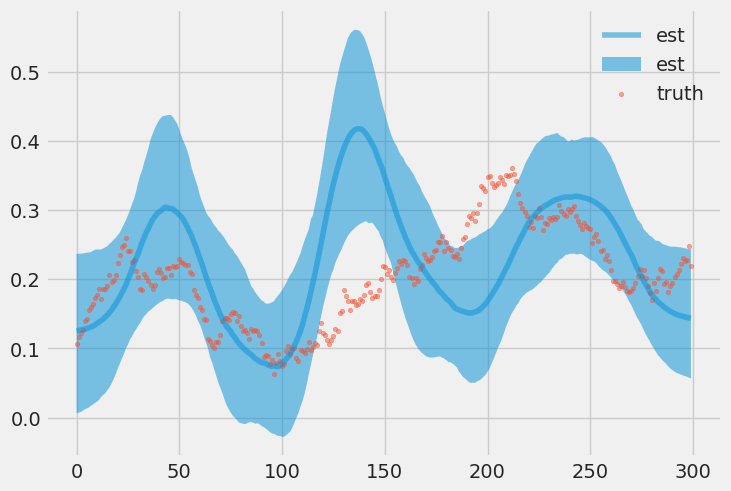

In [9]:
coef_mid, coef_lower, coef_upper  = ktrx_neutral.get_regression_coefs(include_ci=True, coefficient_method='empirical')

x = np.arange(coef_mid.shape[0])

plt.plot(x, coef_mid['x{}'.format(idx)], label='est', alpha=0.5)
plt.fill_between(x, coef_lower['x{}'.format(idx)], coef_upper['x{}'.format(idx)], label='est', alpha=0.5)
plt.scatter(x, rw_data['beta{}'.format(idx)], label='truth', s=10, alpha=0.5)
plt.legend();

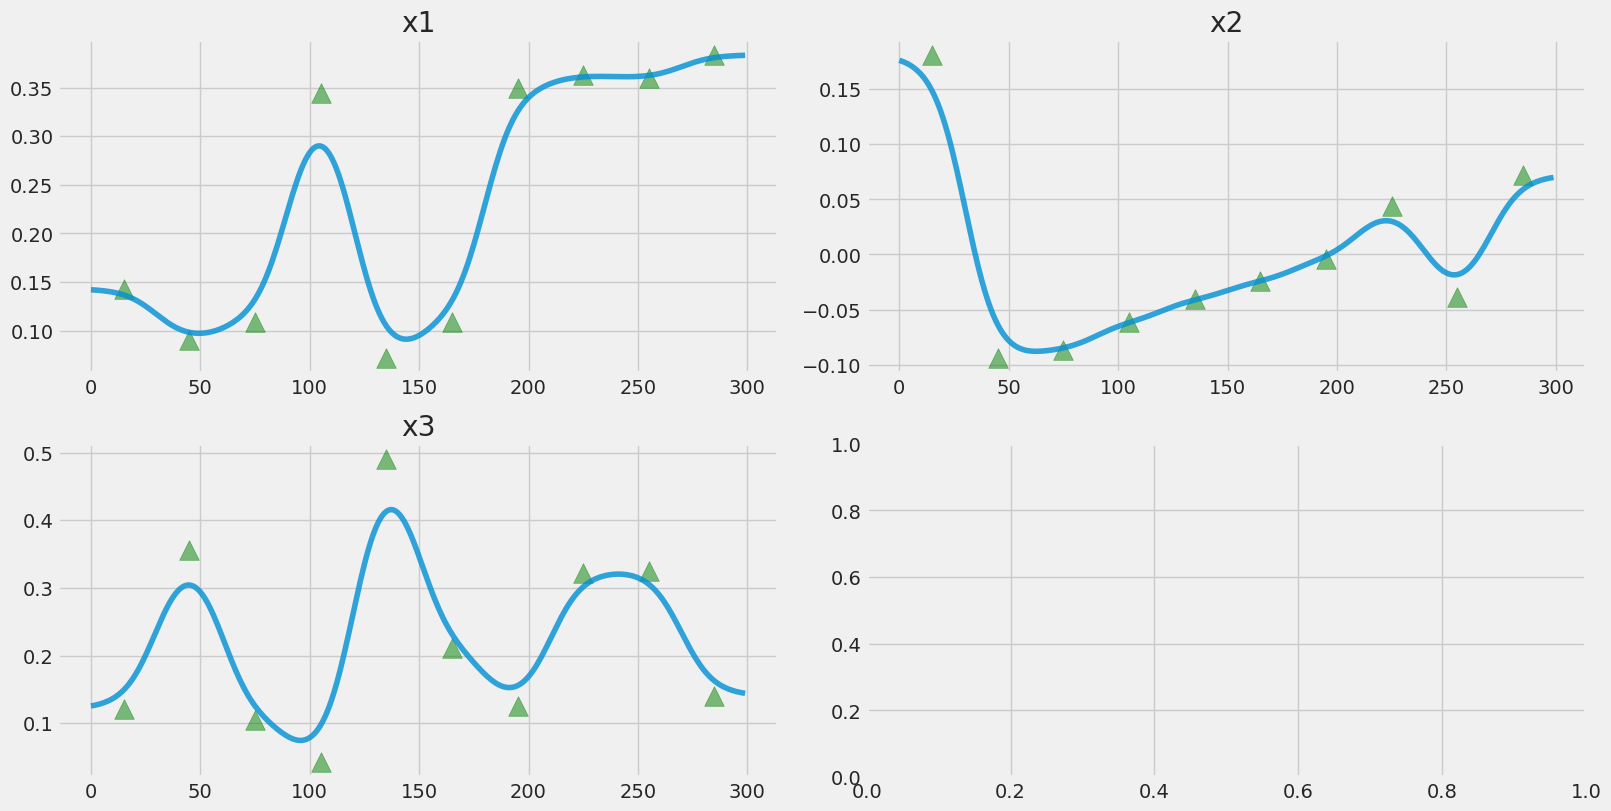

In [10]:
_ = ktrx_neutral.plot_regression_coefs(with_knot=True, figsize=(16, 8))

## Hierarchical structure with positive sign assumption

Most of setting are similar to previous setting.  However, this time we turn on sign as positive which implies all coefficient distribution are replaced by folded normal.

In [11]:
%%time
ktrx_pos = KTRXFull(response_col=response_col,
                    date_col='date',
                    level_knot_scale=level_knot_scale,
                    level_knot_dates=level_knot_dates,
                    level_knots=level_knots_stan,

                    regressor_col=regressor_col,
                    regressor_init_knot_loc=[0] * len(regressor_col),
                    regressor_init_knot_scale=[1.0] * len(regressor_col),
                    regressor_knot_scale=[0.5] * len(regressor_col),
                    # this is the only change fromp previous setting
                    regressor_sign=['+'] * len(regressor_col),

                    span_coefficients=0.1,
                    rho_coefficients=0.05, 
                    prediction_percentiles=[2.5, 97.5],
                    seed=2020,
                    num_steps=501,
                    num_sample=1000,
                    learning_rate=0.2,
                    learning_rate_total_decay=0.05,
                    verbose=True,
                    message=50,
                    n_bootstrap_draws=-1,
                    estimator_type=PyroEstimatorVI, 
    
                    # new setting we want to test
                    mvn=0,
                    flat_multiplier=True,
                    geometric_walk=False,
                    min_residuals_sd=1.0)

ktrx_pos.fit(df=rw_data)                                  

INFO:root:Guessed max_plate_nesting = 1


step    0 loss = 1756.9, scale = 0.12249
step   50 loss = 896.61, scale = 0.60583
step  100 loss = 895.35, scale = 0.55931
step  150 loss = 894.87, scale = 0.55036
step  200 loss = 894.3, scale = 0.5609
step  250 loss = 894.77, scale = 0.55182
step  300 loss = 894.76, scale = 0.55724
step  350 loss = 894.34, scale = 0.55437
step  400 loss = 894.64, scale = 0.55467
step  450 loss = 894.36, scale = 0.55941
step  500 loss = 893.72, scale = 0.55694
CPU times: user 18.9 s, sys: 23.2 ms, total: 18.9 s
Wall time: 4.79 s


In [12]:
idx = 3

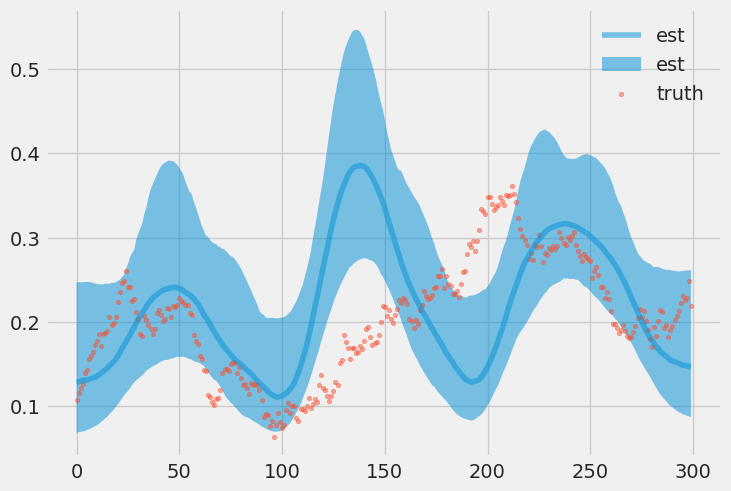

In [13]:
coef_mid, coef_lower, coef_upper  = ktrx_pos.get_regression_coefs(include_ci=True, coefficient_method='empirical')

x = np.arange(coef_mid.shape[0])

plt.plot(x, coef_mid['x{}'.format(idx)], label='est', alpha=0.5)
plt.fill_between(x, coef_lower['x{}'.format(idx)], coef_upper['x{}'.format(idx)], label='est', alpha=0.5)
plt.scatter(x, rw_data['beta{}'.format(idx)], label='truth', s=10, alpha=0.5)
plt.legend();

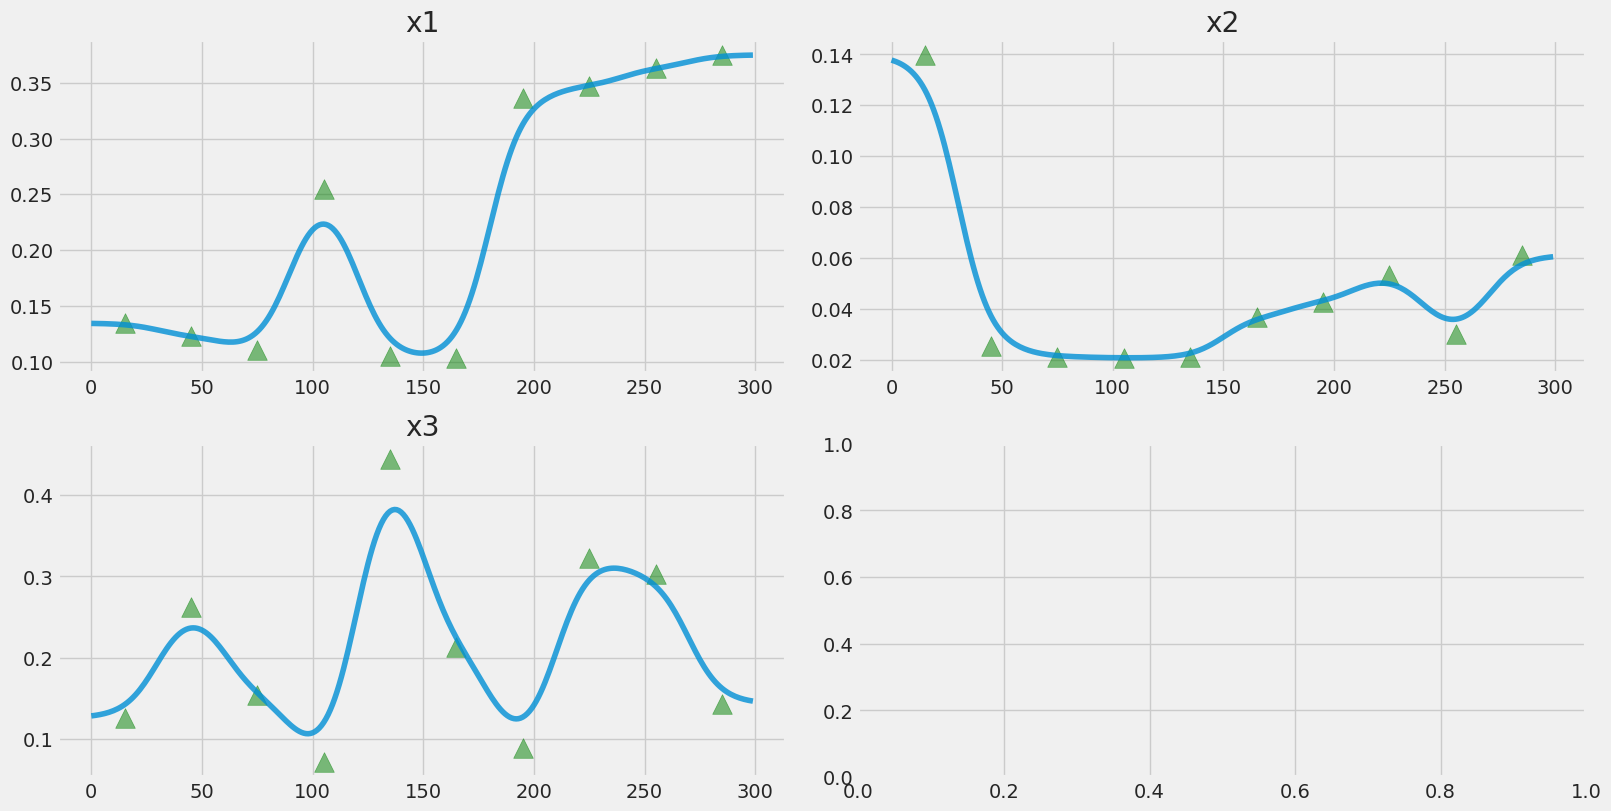

In [14]:
_ = ktrx_pos.plot_regression_coefs(with_knot=True, figsize=(16, 8))

## Gemetric random walk structure with positive sign assumption and 

Most of setting are similar to previous setting.  However, this time we turn on sign as positive which implies all coefficient distribution are replaced by folded normal.

In [15]:
%%time
ktrx_grw = KTRXFull(response_col=response_col,
                    date_col='date',
                    level_knot_scale=level_knot_scale,
                    level_knot_dates=level_knot_dates,
                    level_knots=level_knots_stan,

                    regressor_col=regressor_col,
                    regressor_init_knot_loc=[0] * len(regressor_col),
    
                    # since we turn geometric_walk to true, this setting also need to be changed from previous
                    # i.e. scale parameter is interpreted differently
                    regressor_init_knot_scale=[1.0] * len(regressor_col),
                    regressor_knot_scale=[0.5] * len(regressor_col),
                    regressor_sign=['+'] * len(regressor_col),

                    span_coefficients=0.1,
                    rho_coefficients=0.05, 
                    prediction_percentiles=[2.5, 97.5],
                    seed=2020,
                    num_steps=501,
                    num_sample=1000,
                    learning_rate=0.2,
                    learning_rate_total_decay=0.05,
                    verbose=True,
                    message=50,
                    n_bootstrap_draws=-1,
                    estimator_type=PyroEstimatorVI, 
    
                    # new setting we want to test
                    mvn=0,
                    flat_multiplier=True,
                    geometric_walk=True,
                    min_residuals_sd=1.0)

ktrx_grw.fit(df=rw_data)                                  

INFO:root:Guessed max_plate_nesting = 1


step    0 loss = 2289.3, scale = 0.10606
step   50 loss = 898.15, scale = 0.33726
step  100 loss = 885.82, scale = 0.37539
step  150 loss = 883.46, scale = 0.39269
step  200 loss = 882.44, scale = 0.37538
step  250 loss = 881.65, scale = 0.39174
step  300 loss = 880.48, scale = 0.39028
step  350 loss = 880.83, scale = 0.39621
step  400 loss = 881.51, scale = 0.39376
step  450 loss = 880.3, scale = 0.40089
step  500 loss = 880.82, scale = 0.39982
CPU times: user 17.5 s, sys: 55 ms, total: 17.6 s
Wall time: 4.43 s


In [16]:
idx = 3

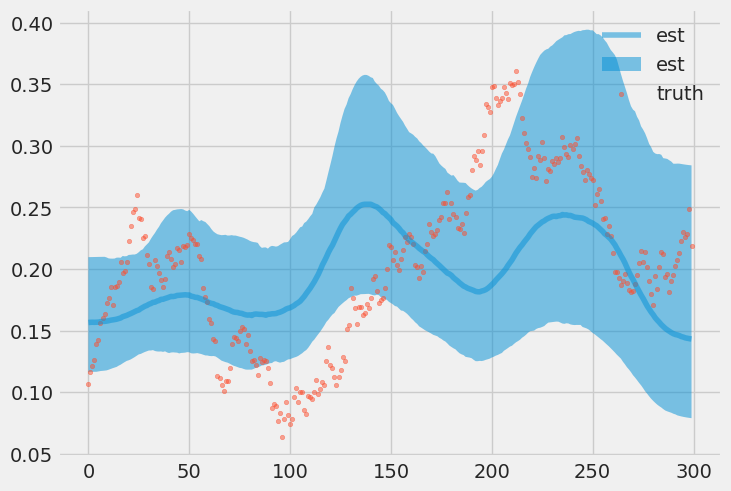

In [17]:
coef_mid, coef_lower, coef_upper  = ktrx_grw.get_regression_coefs(include_ci=True, coefficient_method='empirical')

x = np.arange(coef_mid.shape[0])

plt.plot(x, coef_mid['x{}'.format(idx)], label='est', alpha=0.5)
plt.fill_between(x, coef_lower['x{}'.format(idx)], coef_upper['x{}'.format(idx)], label='est', alpha=0.5)
plt.scatter(x, rw_data['beta{}'.format(idx)], label='truth', s=10, alpha=0.5)
plt.legend();

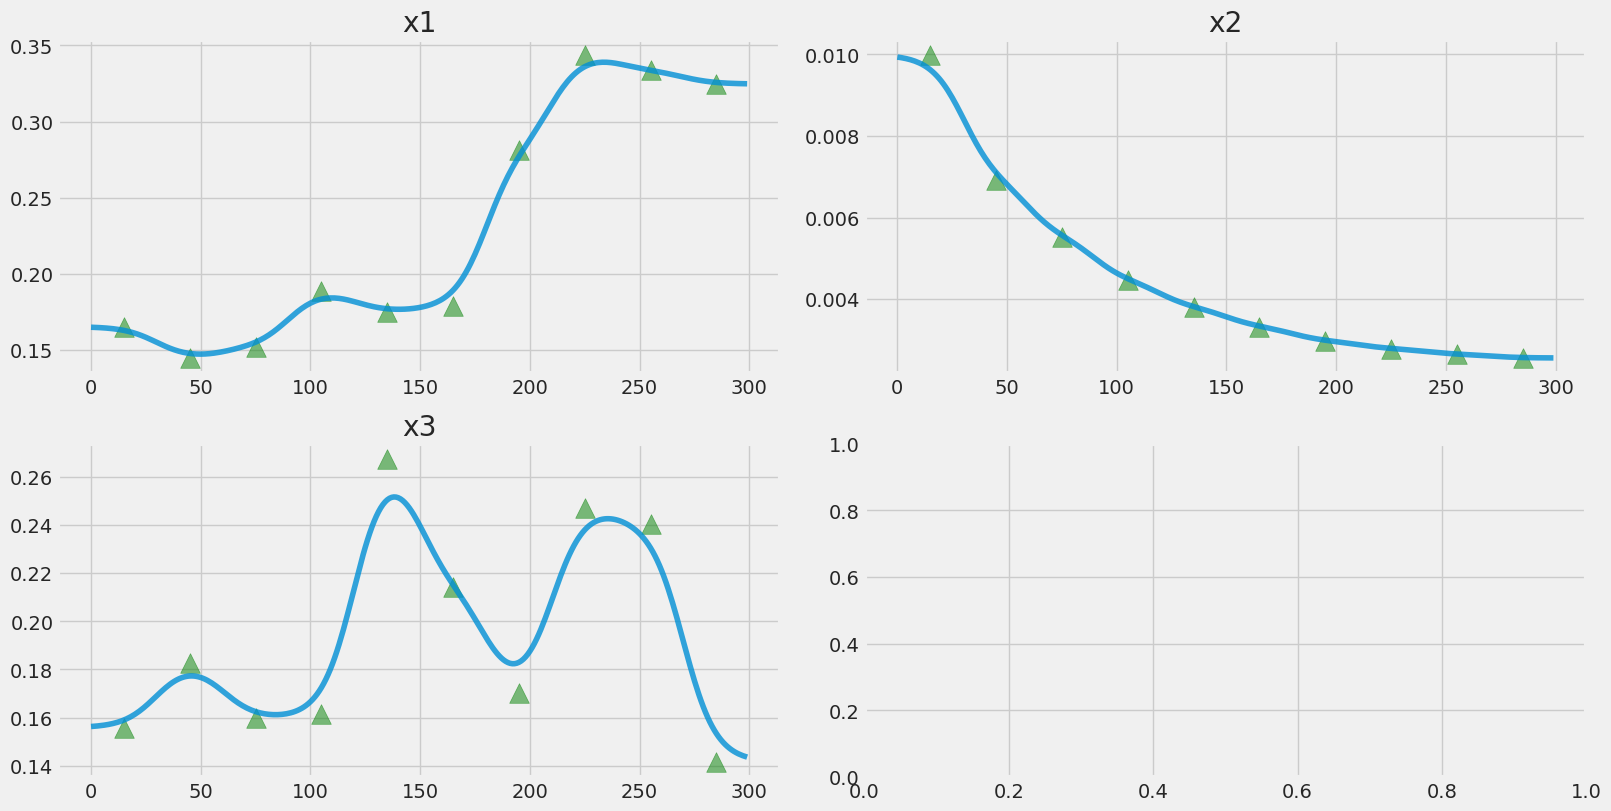

In [18]:
_ = ktrx_grw.plot_regression_coefs(with_knot=True, figsize=(16, 8))

# Sine-cosine coefficients Simulation Study

## KTRLite

**KTRLite** is used to learn the trend.  We will use a default to do that.

In [19]:
p = 3
# define independent and response variables
regressor_col = ['x{}'.format(pp) for pp in range(1, p+1)]
response_col = 'y'


# run the model 
# run lite first 
ktr_lite = KTRLiteMAP(response_col=response_col,
                      date_col='date',
                      seed=2020,
                      estimator_type=StanEstimatorMAP)

ktr_lite.fit(df=seas_data)

level_knot_scale = ktr_lite.level_knot_scale
level_knots_stan = ktr_lite._aggregate_posteriors['map']['lev_knot'][0]
level_knot_dates = ktr_lite._level_knot_dates
level_knots_stan = np.array([0] * len(level_knot_dates))

Initial log joint probability = -4480.74
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19      -3512.62     0.0595158       5.47331           1           1       24   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39      -3512.29    0.00157563       5.52065       1.329      0.4599       55   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      56      -3512.28   8.09664e-06       6.10491   1.418e-06       0.001      116  LS failed, Hessian reset 
      59      -3512.28   6.29481e-06       5.52163      0.8515      0.8515      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      62      -3512.28   4.41608e-07       5.76053     0.04884           1      124   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


## Hierarchical structure with neutral sign assumption

Each coefficient follow Normal dist. with a latent mean which also follows a Normal dist.

In [20]:
%%time
ktrx_neutral = KTRXFull(response_col=response_col,
                        date_col='date',
                        level_knot_scale=level_knot_scale,
                        level_knot_dates=level_knot_dates,
                        level_knots=level_knots_stan,

                        regressor_col=regressor_col,
                        regressor_init_knot_loc=[0] * len(regressor_col),
                        regressor_init_knot_scale=[10.0] * len(regressor_col),
                        regressor_knot_scale=[2.0] * len(regressor_col),

                        span_coefficients=0.1,
                        rho_coefficients=0.05, 
                        prediction_percentiles=[2.5, 97.5],
                        seed=2020,
                        num_steps=501,
                        num_sample=1000,
                        learning_rate=0.2,
                        learning_rate_total_decay=0.05,
                        verbose=True,
                        message=50,
                        n_bootstrap_draws=-1,
                        estimator_type=PyroEstimatorVI, 
    
                        # new setting we want to test
                        mvn=0,
                        flat_multiplier=True,
                        geometric_walk=False,
                        min_residuals_sd=1.0)

ktrx_neutral.fit(df=seas_data)                                  

INFO:root:Guessed max_plate_nesting = 1


step    0 loss = 5457.6, scale = 0.1381
step   50 loss = 4028.3, scale = 0.41104
step  100 loss = 4025.6, scale = 0.4132
step  150 loss = 4025.8, scale = 0.41267
step  200 loss = 4025.6, scale = 0.41341
step  250 loss = 4025.7, scale = 0.40878
step  300 loss = 4025.2, scale = 0.4103
step  350 loss = 4025.1, scale = 0.40697
step  400 loss = 4025.1, scale = 0.4124
step  450 loss = 4025.1, scale = 0.4153
step  500 loss = 4024.9, scale = 0.41118
CPU times: user 24.4 s, sys: 50.9 ms, total: 24.5 s
Wall time: 6.18 s


In [21]:
idx = 3

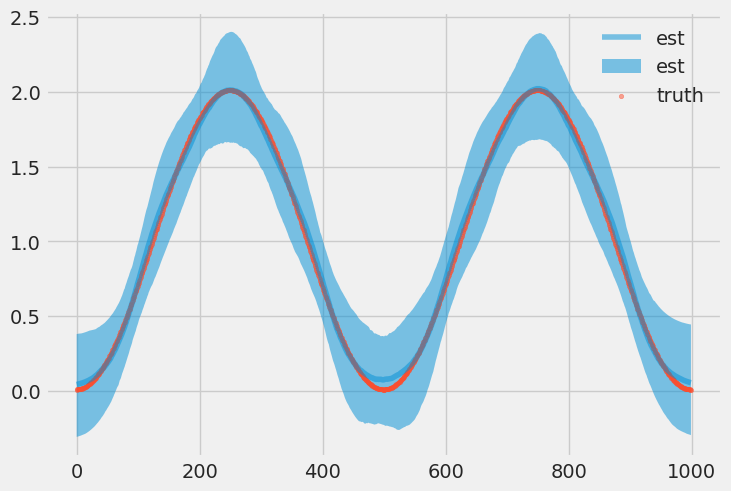

In [22]:
coef_mid, coef_lower, coef_upper  = ktrx_neutral.get_regression_coefs(include_ci=True, coefficient_method='empirical')

x = np.arange(coef_mid.shape[0])

plt.plot(x, coef_mid['x{}'.format(idx)], label='est', alpha=0.5)
plt.fill_between(x, coef_lower['x{}'.format(idx)], coef_upper['x{}'.format(idx)], label='est', alpha=0.5)
plt.scatter(x, seas_data['beta{}'.format(idx)], label='truth', s=10, alpha=0.5)
plt.legend();

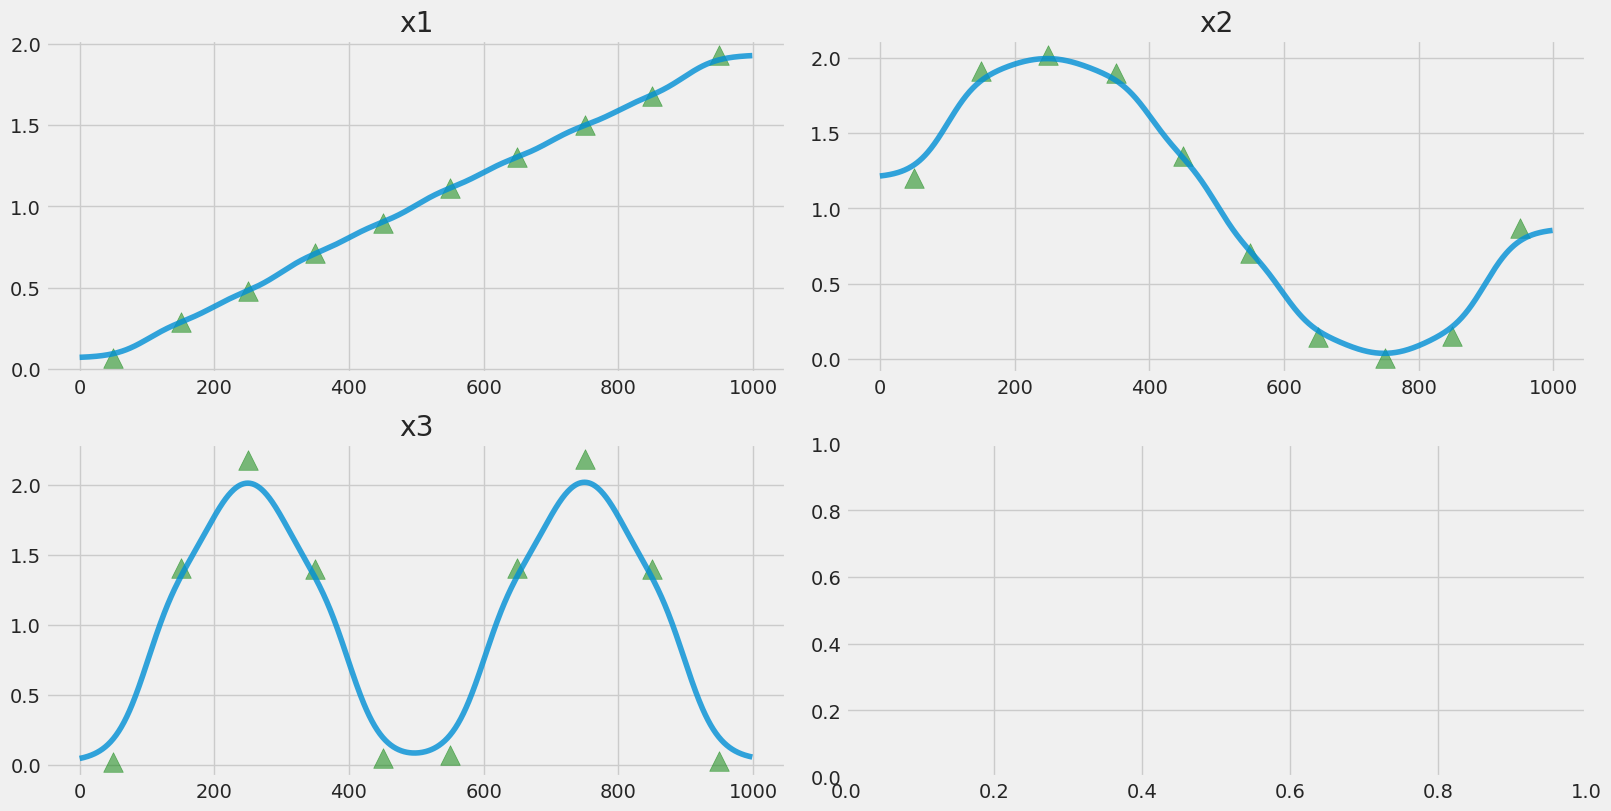

In [23]:
_ = ktrx_neutral.plot_regression_coefs(with_knot=True, figsize=(16, 8))

## Hierarchical structure with positive sign assumption

Most of setting are similar to previous setting.  However, this time we turn on sign as positive which implies all coefficient distribution are replaced by folded normal.

In [24]:
%%time
ktrx_pos = KTRXFull(response_col=response_col,
                    date_col='date',
                    level_knot_scale=level_knot_scale,
                    level_knot_dates=level_knot_dates,
                    level_knots=level_knots_stan,

                    regressor_col=regressor_col,
                    regressor_init_knot_loc=[0] * len(regressor_col),
                    regressor_init_knot_scale=[10.0] * len(regressor_col),
                    regressor_knot_scale=[2.0] * len(regressor_col),
                    # this is the only change fromp previous setting
                    regressor_sign=['+'] * len(regressor_col),

                    span_coefficients=0.1,
                    rho_coefficients=0.05, 
                    prediction_percentiles=[2.5, 97.5],
                    seed=2020,
                    num_steps=501,
                    num_sample=1000,
                    learning_rate=0.2,
                    learning_rate_total_decay=0.05,
                    verbose=True,
                    message=50,
                    n_bootstrap_draws=-1,
                    estimator_type=PyroEstimatorVI, 
    
                    # new setting we want to test
                    mvn=0,
                    flat_multiplier=True,
                    geometric_walk=False,
                    min_residuals_sd=1.0)

ktrx_pos.fit(df=seas_data)                                  

INFO:root:Guessed max_plate_nesting = 1


step    0 loss = 9449.2, scale = 0.10646
step   50 loss = 4026.9, scale = 0.49181
step  100 loss = 4016.1, scale = 0.4838
step  150 loss = 4015.8, scale = 0.48571
step  200 loss = 4015.5, scale = 0.49094
step  250 loss = 4015.7, scale = 0.48516
step  300 loss = 4015.8, scale = 0.47995
step  350 loss = 4015.3, scale = 0.4868
step  400 loss = 4015.7, scale = 0.48274
step  450 loss = 4015.4, scale = 0.49066
step  500 loss = 4015.1, scale = 0.48553
CPU times: user 26.1 s, sys: 59.2 ms, total: 26.2 s
Wall time: 6.58 s


In [25]:
idx = 3

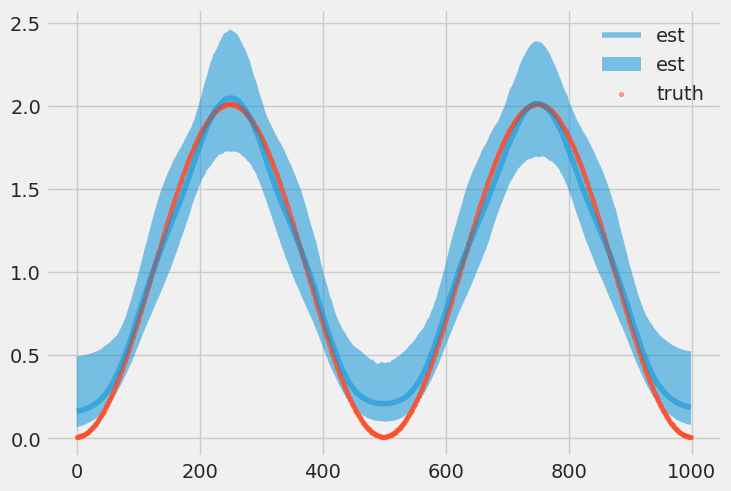

In [26]:
coef_mid, coef_lower, coef_upper  = ktrx_pos.get_regression_coefs(include_ci=True, coefficient_method='empirical')

x = np.arange(coef_mid.shape[0])

plt.plot(x, coef_mid['x{}'.format(idx)], label='est', alpha=0.5)
plt.fill_between(x, coef_lower['x{}'.format(idx)], coef_upper['x{}'.format(idx)], label='est', alpha=0.5)
plt.scatter(x, seas_data['beta{}'.format(idx)], label='truth', s=10, alpha=0.5)
plt.legend();

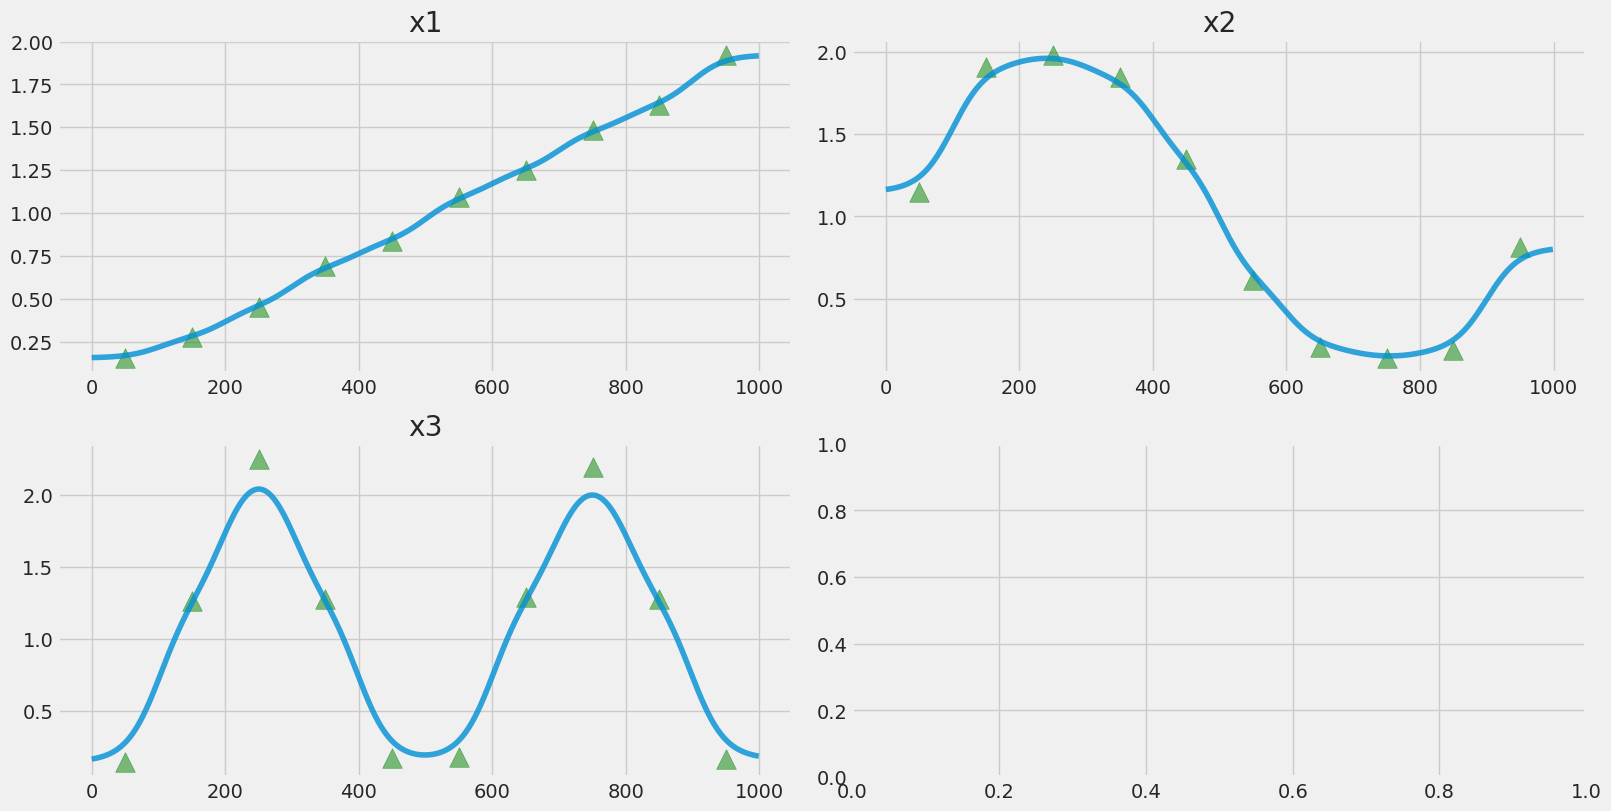

In [27]:
_ = ktrx_pos.plot_regression_coefs(with_knot=True, figsize=(16, 8))

## Gemetric random walk structure with positive sign assumption and 

Most of setting are similar to previous setting.  However, this time we turn on sign as positive which implies all coefficient distribution are replaced by folded normal.

In [28]:
%%time
ktrx_grw = KTRXFull(response_col=response_col,
                    date_col='date',
                    level_knot_scale=level_knot_scale,
                    level_knot_dates=level_knot_dates,
                    level_knots=level_knots_stan,

                    regressor_col=regressor_col,
                    regressor_init_knot_loc=[0] * len(regressor_col),
    
                    # since we turn geometric_walk to true, this setting also need to be changed from previous
                    # i.e. scale parameter is interpreted differently
                    regressor_init_knot_scale=[10.0] * len(regressor_col),
                    regressor_knot_scale=[0.2] * len(regressor_col),
                    regressor_sign=['+'] * len(regressor_col),
    
                    span_coefficients=0.1,
                    rho_coefficients=0.05, 
                    prediction_percentiles=[2.5, 97.5],
                    seed=2020,
                    num_steps=501,
                    num_sample=1000,
                    learning_rate=0.2,
                    learning_rate_total_decay=0.05,
                    verbose=True,
                    message=50,
                    n_bootstrap_draws=-1,
                    estimator_type=PyroEstimatorVI, 
    
                    # new setting we want to test
                    mvn=0,
                    flat_multiplier=True,
                    geometric_walk=True,
                    min_residuals_sd=1.0)

ktrx_grw.fit(df=seas_data)                                  

INFO:root:Guessed max_plate_nesting = 1


step    0 loss = 11049, scale = 0.10653
step   50 loss = 4078.9, scale = 0.31172
step  100 loss = 4057, scale = 0.30146
step  150 loss = 4054, scale = 0.30529
step  200 loss = 4052.3, scale = 0.31135
step  250 loss = 4051.6, scale = 0.3015
step  300 loss = 4049.7, scale = 0.30393
step  350 loss = 4050.2, scale = 0.30503
step  400 loss = 4051.5, scale = 0.30586
step  450 loss = 4049.7, scale = 0.31083
step  500 loss = 4049.1, scale = 0.30622
CPU times: user 28.5 s, sys: 50.8 ms, total: 28.6 s
Wall time: 7.2 s


In [29]:
idx = 3

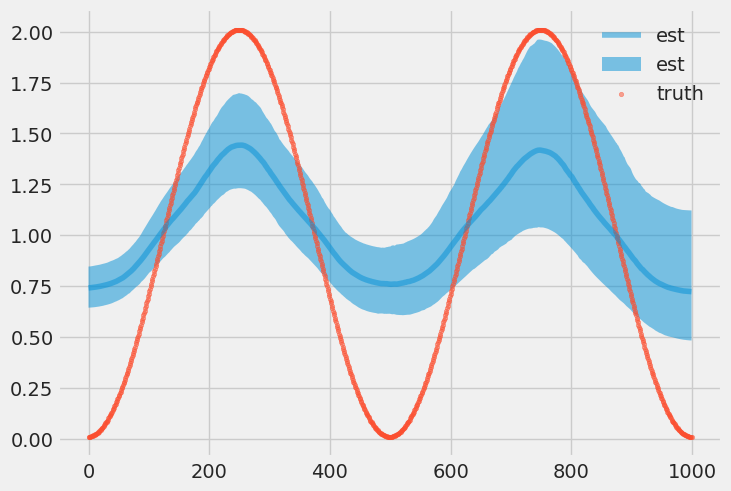

In [30]:
coef_mid, coef_lower, coef_upper  = ktrx_grw.get_regression_coefs(include_ci=True, coefficient_method='empirical')

x = np.arange(coef_mid.shape[0])

plt.plot(x, coef_mid['x{}'.format(idx)], label='est', alpha=0.5)
plt.fill_between(x, coef_lower['x{}'.format(idx)], coef_upper['x{}'.format(idx)], label='est', alpha=0.5)
plt.scatter(x, seas_data['beta{}'.format(idx)], label='truth', s=10, alpha=0.5)
plt.legend();

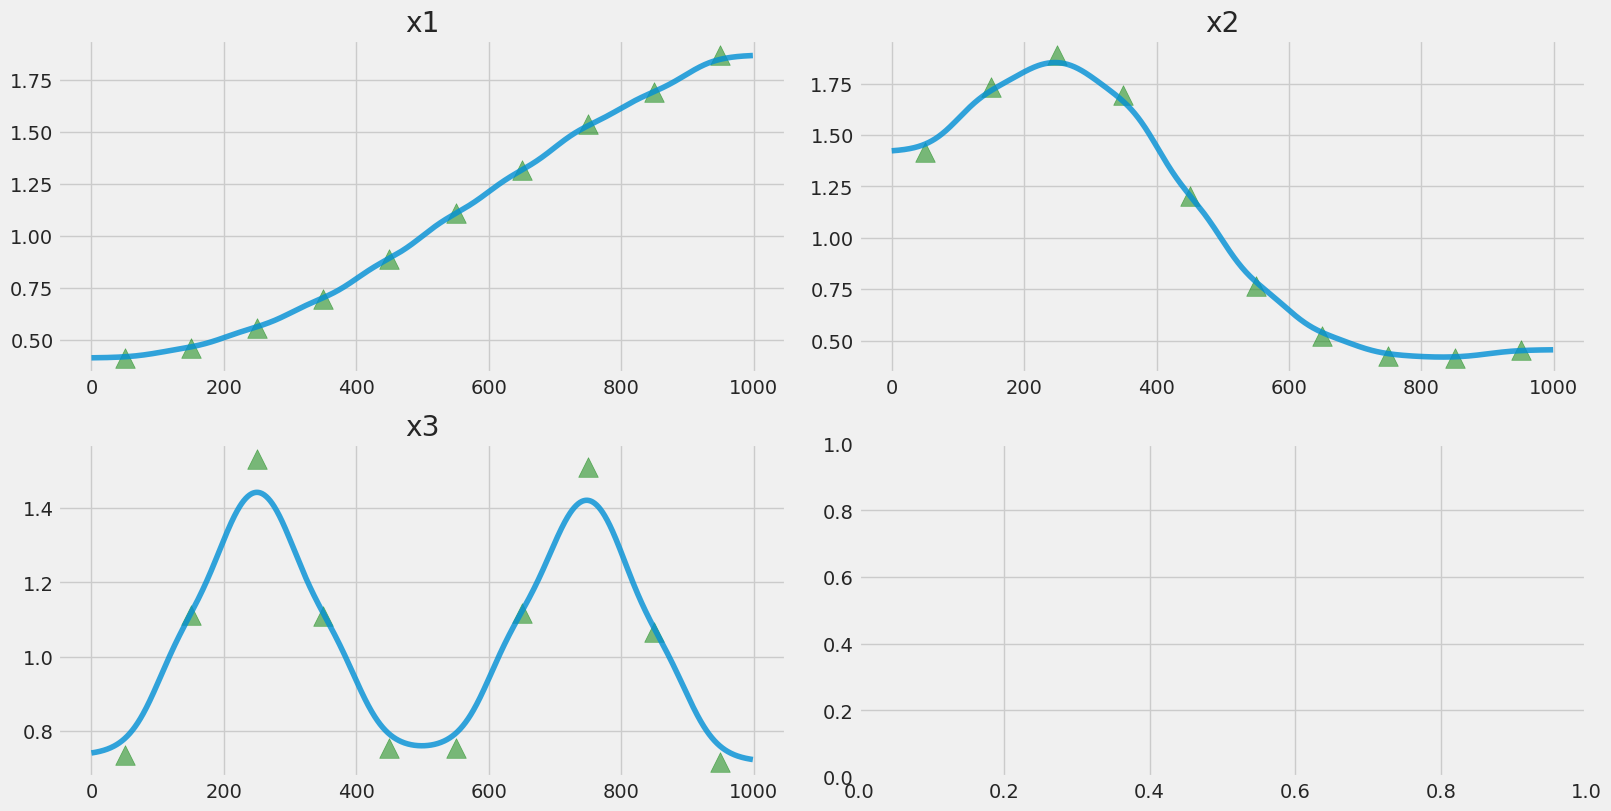

In [31]:
_ = ktrx_grw.plot_regression_coefs(with_knot=True, figsize=(16, 8))

In [32]:
# def multiple_test(N, n, sim_type):
#     out = pd.DataFrame()
#     out['index'] = range(0, N)
#     # for hte model fit 
#     out['time_1'] = 0.0
#     out['time_2'] = 0.0
    
#     out['SSE_1'] = 0.0
#     out['SSE_2'] = 0.0
#     out['RMSE_1'] = 0.0
#     out['RMSE_2'] = 0.0
#     out['max_error_1'] = 0.0
#     out['max_error_2'] = 0.0
    
#     # for the true values 
#     out['SSE_beta1_1'] = 0.0
#     out['SSE_beta1_2'] = 0.0 
#     out['SSE_beta2_1'] = 0.0   
#     out['SSE_beta2_2'] = 0.0
#     out['SSE_beta3_1'] = 0.0
#     out['SSE_beta3_2'] = 0.0

    
#     for i in range(0, N):
#         # simulate the data 
#         if sim_type == 'sea':
#             data = sim_data_seasonal(n = n, RS = 1000+i)
       
#         if sim_type == 'rw':
#             data = sim_data_rw(n = n, RS = 1000+i, p=3)    
    
#         #print(data.head())
    
#         # define stuff 
#         regressor_col=['x1', 'x2', 'x3']
#         response_col = 'y'
#         # run the model 
#         # run lite first 
#         ktr_lite = KTRLiteMAP(
#             response_col=response_col,
#             date_col='date',
#             level_knot_scale=1,
#             seed=2000+i,
#             span_level= .1, 
#             estimator_type=StanEstimatorMAP,
#         )
#         ktr_lite.fit(df=data)
#         level_knot_scale = ktr_lite.level_knot_scale
#         level_knots_stan = ktr_lite._aggregate_posteriors['map']['lev_knot'][0]
#         level_knot_dates = ktr_lite._level_knot_dates
#         level_knots_stan = np.array([0] * len(level_knot_dates))
        
#         ktrx1 = KTRXFull(
#             response_col=response_col,
#             date_col='date',

#             degree_of_freedom=30,
#             level_knot_scale=level_knot_scale,
#             level_knot_dates=level_knot_dates,
#             level_knots=level_knots_stan,

#             regressor_col=regressor_col,
#             regressor_knot_pooling_loc=[0] * len(regressor_col),
#             regressor_knot_pooling_scale=[1] * len(regressor_col),
# #             regressor_knot_scale=[1.0] * len(regressor_col),

#             span_coefficients=0.1,
#             rho_coefficients=0.1, 
#             prediction_percentiles=[2.5, 97.5],
#             seed=2000+i,
#             num_steps=1000,
#             num_sample=3000,
#             verbose=False,
#             message=100,
#             n_bootstrap_draws=-1,
#             estimator_type=PyroEstimatorVI,
#             mvn=1
#         )

#         ktrx2 = KTRXFull(
#             response_col=response_col,
#             date_col='date',

#             degree_of_freedom=30,
#             level_knot_scale=level_knot_scale,
#             level_knot_dates=level_knot_dates,
#             level_knots=level_knots_stan,

#             regressor_col=regressor_col,
#             regressor_knot_pooling_loc=[0] * len(regressor_col),
#             regressor_knot_pooling_scale=[1] * len(regressor_col),
#             regressor_knot_scale=[1.0] * len(regressor_col),

#             span_coefficients=0.1,
#             rho_coefficients=0.1, 
#             prediction_percentiles=[2.5, 97.5],
#             seed=2000+i,
#             num_steps=1000,
#             num_sample=3000,
#             verbose=False,
#             message=100,
#             n_bootstrap_draws=-1,
#             estimator_type=PyroEstimatorVI,
#         )
        
#         # fit the models and recod the times
#         start_time = time.time()
#         ktrx1.fit(df=data)
#         time_1 = time.time() - start_time
        
#         start_time = time.time()
#         ktrx2.fit(df=data)
#         time_2 = time.time() - start_time
        
#         # get the predictions 
#         predicted_df_1 = ktrx1.predict(df=data)
#         predicted_df_2 = ktrx2.predict(df=data)
            
#         # compare to observations  
#         SSE_1 = sum((predicted_df_1['prediction'] - data['y'])**2.0 )
#         SSE_2 = sum((predicted_df_2['prediction'] - data['y'])**2.0 )
        
#         max_misfit_1 = max(abs(predicted_df_1['prediction'] - data['y']) )
#         max_misfit_2 = max(abs(predicted_df_2['prediction'] - data['y']) )
    
#         out.at[i, 'time_1'] = time_1 
#         out.at[i, 'time_2'] = time_2 
    
#         out.at[i, 'SSE_1'] = SSE_1 
#         out.at[i, 'SSE_2'] = SSE_2 
        
#         out.at[i, 'RMSE_1'] = (SSE_1/n)**(0.5) 
#         out.at[i, 'RMSE_2'] = (SSE_2/n)**(0.5) 
        
        
#         out.at[i, 'max_error_1'] = max_misfit_1
#         out.at[i, 'max_error_2'] = max_misfit_2
        
#         #compare to true values 
#         coef_df_1= ktrx1.get_regression_coefs(
#         aggregate_method='median',
#         include_ci=False)
        
#         coef_df_2= ktrx2.get_regression_coefs(
#         aggregate_method='median',
#         include_ci=False)
        
#         SSE_beta1_1 = sum((coef_df_1['x1']-data['beta1'])**2.0)
#         SSE_beta2_1 = sum((coef_df_1['x2']-data['beta2'])**2.0)
#         SSE_beta3_1 = sum((coef_df_1['x3']-data['beta3'])**2.0)
#         SSE_beta1_2 = sum((coef_df_2['x1']-data['beta1'])**2.0)
#         SSE_beta2_2 = sum((coef_df_2['x2']-data['beta2'])**2.0)
#         SSE_beta3_2 = sum((coef_df_2['x3']-data['beta3'])**2.0)    
        
#         out.at[i,'SSE_beta1_1'] = SSE_beta1_1
#         out.at[i,'SSE_beta2_1'] = SSE_beta2_1
#         out.at[i,'SSE_beta3_1'] = SSE_beta3_1
#         out.at[i,'SSE_beta1_2'] = SSE_beta1_2
#         out.at[i,'SSE_beta2_2'] = SSE_beta2_2
#         out.at[i,'SSE_beta3_2'] = SSE_beta3_2
        
#     return out


In [33]:
# out = multiple_test(N=2, n=300, sim_type='sea')

In [34]:
# multiple_test(N=3, n=300, sim_type='rw')